In [80]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import ConfusionMatrixDisplay

In [39]:
data = pd.read_csv('./apple_data.csv', encoding = 'ISO-8859-1')
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...
3881,623499442,True,golden,13,NaN,3,0.7757,Tue Dec 09 22:08:53 +0000 2014,5.420000e+17,#AAPL OR @Apple,5\n3,(Via FC) Apple Is Warming Up To Social Media -...
3882,623499450,True,golden,16,NaN,3,0.6225,Tue Dec 09 22:18:27 +0000 2014,5.420000e+17,#AAPL OR @Apple,3\n1,RT @MMLXIV: there is no avocado emoji may I as...
3883,623499486,True,golden,14,NaN,5,0.9347,Tue Dec 09 23:45:59 +0000 2014,5.420000e+17,#AAPL OR @Apple,5,@marcbulandr I could not agree more. Between @...
3884,623499514,True,golden,13,NaN,1,0.9230,Wed Dec 10 00:48:10 +0000 2014,5.420000e+17,#AAPL OR @Apple,1,My iPhone 5's photos are no longer downloading...


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [90]:
data1 = data[['text', 'sentiment']]
data1

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3
...,...,...
3881,(Via FC) Apple Is Warming Up To Social Media -...,3
3882,RT @MMLXIV: there is no avocado emoji may I as...,3
3883,@marcbulandr I could not agree more. Between @...,5
3884,My iPhone 5's photos are no longer downloading...,1


In [91]:
data1["sentiment"].value_counts()

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64

In [92]:
data1 = data1.drop(data1[data1['sentiment'] == "not_relevant"].index)
data1= data1.dropna(ignore_index = True)
data1['sentiment'].value_counts()

sentiment
3    2162
1    1219
5     423
Name: count, dtype: int64

In [94]:
#creating a new column for labels
data1['label'] = ' '

for i in range(len(data1.sentiment)):
    if data1.sentiment[i] == '3':
        data1["label"][i] = 'neutral'
    elif data1.sentiment[i] == '1':
        data1["label"][i] = 'negative'
    else:
        data1["label"][i] = 'positive'
    
data1

,text,sentiment,label
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3,neutral
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3,neutral
2,My cat only chews @apple cords. Such an #Apple...,3,neutral
3,I agree with @jimcramer that the #IndividualIn...,3,neutral
4,Nobody expects the Spanish Inquisition #AAPL,3,neutral
...,...,...,...
3799,(Via FC) Apple Is Warming Up To Social Media -...,3,neutral
3800,RT @MMLXIV: there is no avocado emoji may I as...,3,neutral
3801,@marcbulandr I could not agree more. Between @...,5,positive
3802,My iPhone 5's photos are no longer downloading...,1,negative


C:\Users\marya\AppData\Local\Temp\ipykernel_10040\30028056.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x= 'label', data=data1, palette = 'Set2')


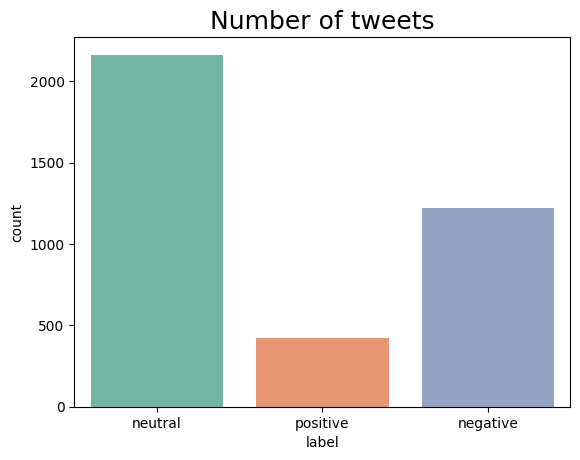

In [95]:
ax1 = sns.countplot(x= 'label', data=data1, palette = 'Set2')
ax1.set_title('Number of tweets', fontsize = 18)
plt.show()

Text(0.5, 1.0, 'Sentiment percentage of tweets')

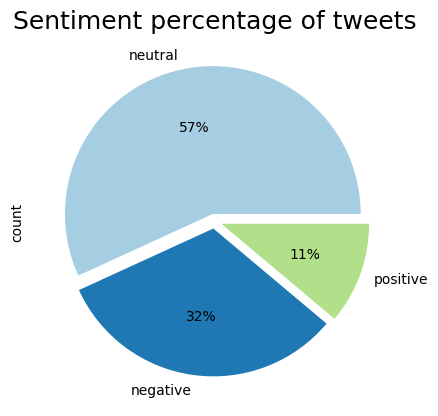

In [46]:
draw = data1['label'].value_counts()
colors = sns.color_palette('Paired')
ax = draw.plot(kind='pie',autopct='%1.0f%%', colors = colors, explode = (0.05, 0.05,0.05) )
ax.set_title('Sentiment percentage of tweets', fontsize = 18)

In [59]:
#replacing 5 with 1 and 1 with 0 and dropping neutral
data1['sentiment']= data1['sentiment'].replace(['5','1', '3'], [1,0,2])
data1 = data1.drop(data1[data1['sentiment'] == 2 ].index)
data1= data1.dropna(ignore_index = True)
data1

,text,sentiment,label
0,Top 3 all @Apple #tablets. Damn right! http://...,1,positive
1,CNBCTV: #Apple's margins better than expected?...,1,positive
2,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,0,negative
3,RT @peterpham: Bought my @AugustSmartLock at t...,1,positive
4,@apple Contact sync between Yosemite and iOS8 ...,0,negative
...,...,...,...
1637,RT @shannonmmiller: Love the @Apple is support...,1,positive
1638,hey @apple is it normal for my laptop charger ...,0,negative
1639,@marcbulandr I could not agree more. Between @...,1,positive
1640,My iPhone 5's photos are no longer downloading...,0,negative


In [49]:
data1['sentiment'].value_counts()

sentiment
0    1219
1     423
Name: count, dtype: int64

Pre processing

In [96]:
datac = data1.copy()
datac["clean_text"] = datac['text']
remove_rt = lambda x: re.sub('RT,rt, @\w+: '," ",x)
rt = lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(\w+:\/\/\S+)|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|#[a-zA-Z]+|$[a-zA-Z]+|@[a-zA-Z]+|[,.^_$*%-;鶯!?:]', " ", x)
datac["clean_text"] = datac.clean_text.map(remove_rt).map(rt)
datac["clean_text"] = datac.clean_text.str.lower()
datac

,text,sentiment,label,clean_text
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3,neutral,the best steve jobs emails ever
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3,neutral,rt why aapl stock had a mini flash crash to...
2,My cat only chews @apple cords. Such an #Apple...,3,neutral,my cat only chews cords such an
3,I agree with @jimcramer that the #IndividualIn...,3,neutral,i agree with that the should own not trade...
4,Nobody expects the Spanish Inquisition #AAPL,3,neutral,nobody expects the spanish inquisition
...,...,...,...,...
3799,(Via FC) Apple Is Warming Up To Social Media -...,3,neutral,via fc apple is warming up to social media ...
3800,RT @MMLXIV: there is no avocado emoji may I as...,3,neutral,rt there is no avocado emoji may i ask why
3801,@marcbulandr I could not agree more. Between @...,5,positive,i could not agree more between and on...
3802,My iPhone 5's photos are no longer downloading...,1,negative,my iphone s photos are no longer downloading...


In [67]:
data2 = datac[['clean_text', 'sentiment','label']]
data2

,clean_text,sentiment,label
0,top all damn right,1,positive
1,cnbctv s margins better than expected,1,positive
2,wtf my battery was one second ago and now ...,0,negative
3,rt bought my at the store pretty good ...,1,positive
4,contact sync between yosemite and ios is se...,0,negative
...,...,...,...
1637,rt love the is supporting with workshop...,1,positive
1638,hey is it normal for my laptop charger to be...,0,negative
1639,i could not agree more between and on...,1,positive
1640,my iphone s photos are no longer downloading...,0,negative


Removing Stopwords

In [68]:
#creating stop word list
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
'being', 'below', 'between','both', 'why', 'will', 'with', 'won', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
'further', 'had', 'has', 'have', 'having', 'iphone','iPhone','he', 'her', 'here','hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
'only', 'or', 'other', 'our', 'ours','re','s', 'same', 'she', "shes", 'cnbctv','should', "shouldve",'so', 'some', 'such',
't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them','themselves', 'then', 'there', 'these', 'they', 'this', 'those',
'through', 'to','ourselves', 'out', 'own', 'hey', 'too','under', 'until', 'up', 'very', 'was','we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
'y', 'you', "youd","youll", "youre", "youve", 'your', 'rt', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data2['nostop_word'] = data2['clean_text'].apply(lambda text: remove_stopwords(text))
data2

,clean_text,sentiment,label,nostop_word
0,top all damn right,1,positive,top damn right
1,cnbctv s margins better than expected,1,positive,margins better expected
2,wtf my battery was one second ago and now ...,0,negative,wtf battery one second ago wtf
3,rt bought my at the store pretty good ...,1,positive,bought store pretty good logo match wait install
4,contact sync between yosemite and ios is se...,0,negative,contact sync yosemite ios seriously screwed us...
...,...,...,...,...
1637,rt love the is supporting with workshop...,1,positive,love supporting workshops
1638,hey is it normal for my laptop charger to be...,0,negative,normal laptop charger soldering skin thanks j
1639,i could not agree more between and on...,1,positive,could not agree great things happen
1640,my iphone s photos are no longer downloading...,0,negative,photos no longer downloading automatically lap...


Tokenization

In [69]:
tweet = data2['nostop_word'].apply(lambda x: x.split())
tweet

0                                      [top, damn, right]
1                             [margins, better, expected]
2                   [wtf, battery, one, second, ago, wtf]
3       [bought, store, pretty, good, logo, match, wai...
4       [contact, sync, yosemite, ios, seriously, scre...
                              ...                        
1637                        [love, supporting, workshops]
1638    [normal, laptop, charger, soldering, skin, tha...
1639           [could, not, agree, great, things, happen]
1640    [photos, no, longer, downloading, automaticall...
1641       [excited, named, app, store, best, list, year]
Name: nostop_word, Length: 1642, dtype: object

Stemming

In [70]:
pstem = PorterStemmer()
data2['Normalize_tweets'] = ''
stweet = tweet.apply(lambda x: [pstem.stem(i) for i in x])

for i in range(len(tweet)):
    stweet[i] = ' '.join(stweet[i])

data2['Normalize_tweets'] = stweet
data2

,clean_text,sentiment,label,nostop_word,Normalize_tweets
0,top all damn right,1,positive,top damn right,top damn right
1,cnbctv s margins better than expected,1,positive,margins better expected,margin better expect
2,wtf my battery was one second ago and now ...,0,negative,wtf battery one second ago wtf,wtf batteri one second ago wtf
3,rt bought my at the store pretty good ...,1,positive,bought store pretty good logo match wait install,bought store pretti good logo match wait instal
4,contact sync between yosemite and ios is se...,0,negative,contact sync yosemite ios seriously screwed us...,contact sync yosemit io serious screw use much...
...,...,...,...,...,...
1637,rt love the is supporting with workshop...,1,positive,love supporting workshops,love support workshop
1638,hey is it normal for my laptop charger to be...,0,negative,normal laptop charger soldering skin thanks j,normal laptop charger solder skin thank j
1639,i could not agree more between and on...,1,positive,could not agree great things happen,could not agre great thing happen
1640,my iphone s photos are no longer downloading...,0,negative,photos no longer downloading automatically lap...,photo no longer download automat laptop sync s...


Creating Word Cloud

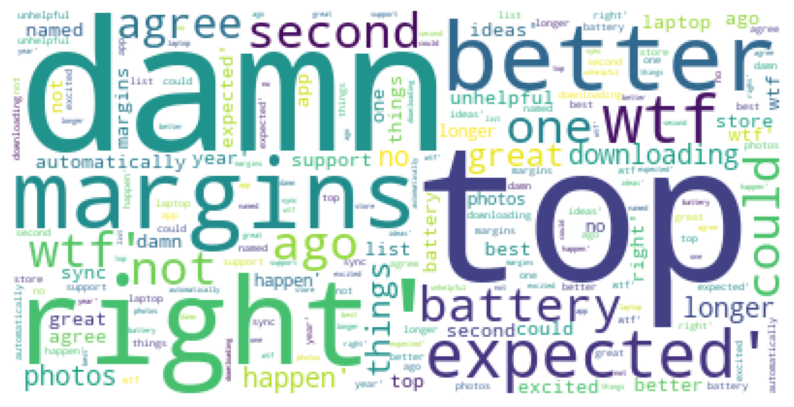

In [71]:
def word_cloud(tweet):
    stopword = set(STOPWORDS)
    w_cloud = WordCloud(background_color='white', max_words=1500,stopwords = stopword,repeat=True).generate(str(tweet))
    plt.figure(figsize=(10,8))
    plt.imshow(w_cloud)
    plt.axis("off")
    plt.show()
word_cloud(data2['nostop_word'].values)

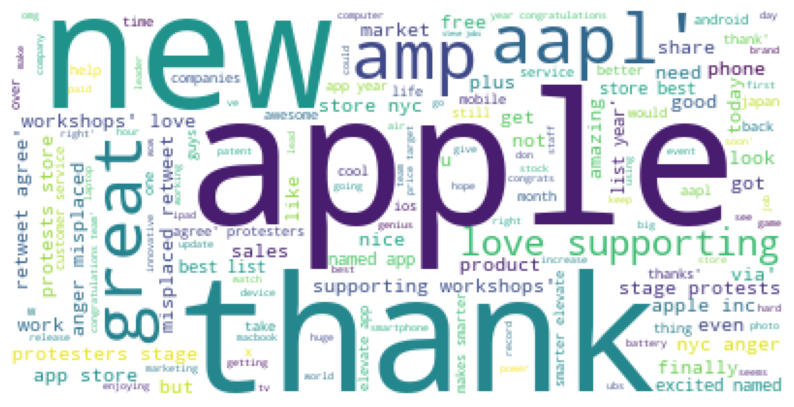

In [72]:
#Creating Wordcloud for all negative tweets
word_cloud(data2[data2["label"]=="positive"]["nostop_word"].values)

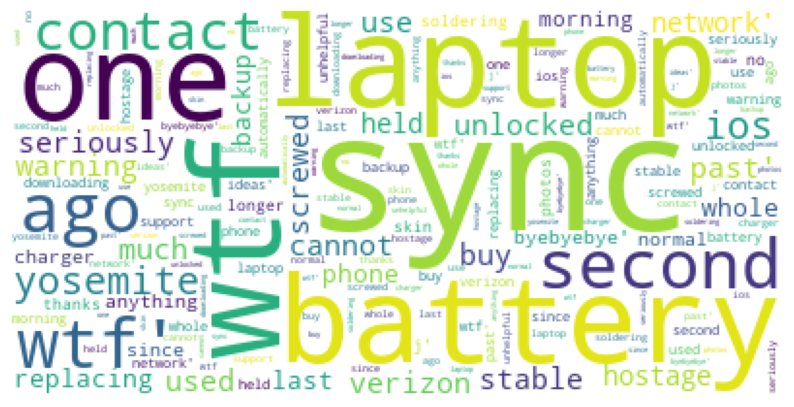

In [73]:
#Creating Wordcloud for all negative tweets
word_cloud(data2[data2["label"]=="negative"]["nostop_word"].values)

Modelling

In [74]:
X = data2['Normalize_tweets']
y = data2['sentiment']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state =10)

In [76]:
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True,encoding="latin-1", ngram_range=(1,2))

In [77]:
X_train_V= vectorizer.fit_transform(X_train.reset_index()["Normalize_tweets"]).toarray()
X_test_V = vectorizer.transform(X_test.reset_index()["Normalize_tweets"]).toarray()

In [78]:
def evaluate(estimator, X_train, X_test, y_train, y_test, y_pred):
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)
    # print scores
    print("Train Values:")
    print(f"Recall: {recall_score(y_train, train_pred).round(2)}")
    print(f"Precision: {precision_score(y_train, train_pred).round(2)}")
    print(f"Accuracy: {accuracy_score(y_train, train_pred).round(2)}")
    print(f"F1 Score: {f1_score(y_train, train_pred).round(2)}")
    print("______________________")
    print("Test Values:")
    print(f"Recall: {recall_score(y_test, test_pred).round(2)}")
    print(f"Precision: {precision_score(y_test, test_pred).round(2)}")
    print(f"Accuracy: {accuracy_score(y_test, test_pred).round(2)}")
    print(f"F1 Score: {f1_score(y_test, test_pred).round(2)}")
    print("______________________")
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, np.round(y_pred))
    plt.show()


C:\Users\marya\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train Values:
Recall: 0.92
Precision: 0.98
Accuracy: 0.97
F1 Score: 0.95
______________________
Test Values:
Recall: 0.69
Precision: 0.76
Accuracy: 0.87
F1 Score: 0.72
______________________
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       123
           1       0.76      0.69      0.72        42

    accuracy                           0.87       165
   macro avg       0.83      0.81      0.82       165
weighted avg       0.86      0.87      0.86       165



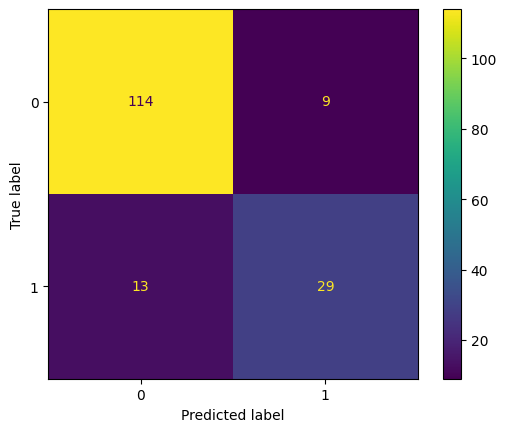

In [81]:
svc = LinearSVC()
svc.fit(X_train_V, y_train)
y_pred_svc = svc.predict(X_test_V)
evaluate(svc, X_train_V, X_test_V, y_train, y_test,y_pred_svc)


Train Values:
Recall: 0.62
Precision: 0.91
Accuracy: 0.89
F1 Score: 0.74
______________________
Test Values:
Recall: 0.4
Precision: 0.85
Accuracy: 0.83
F1 Score: 0.55
______________________
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       123
           1       0.85      0.40      0.55        42

    accuracy                           0.83       165
   macro avg       0.84      0.69      0.72       165
weighted avg       0.83      0.83      0.81       165



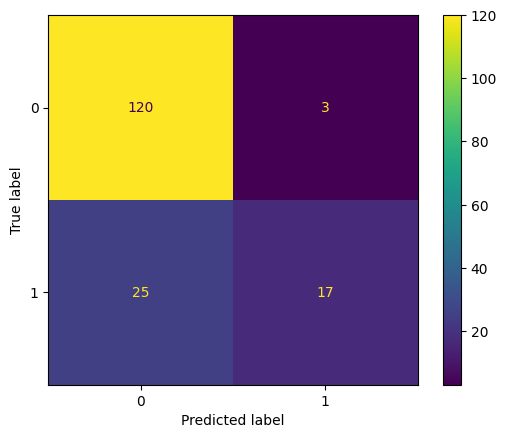

In [82]:
nb = MultinomialNB()
nb.fit(X_train_V, y_train)
y_pred_nb= nb.predict(X_test_V)
evaluate(nb, X_train_V, X_test_V, y_train, y_test,y_pred_nb)

Train Values:
Recall: 0.52
Precision: 0.98
Accuracy: 0.87
F1 Score: 0.68
______________________
Test Values:
Recall: 0.36
Precision: 0.94
Accuracy: 0.83
F1 Score: 0.52
______________________
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       123
           1       0.94      0.36      0.52        42

    accuracy                           0.83       165
   macro avg       0.88      0.67      0.71       165
weighted avg       0.85      0.83      0.80       165



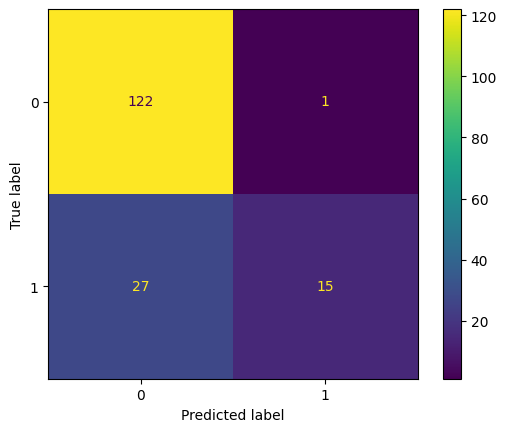

In [83]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train_V, y_train)
y_pred_lr = lr.predict(X_test_V)
evaluate(lr, X_train_V, X_test_V, y_train, y_test,y_pred_lr)


In [84]:
# create new df contains the sentiment and its encoded value, and create two dictionaries
sentiment_id_df = data2[['label', 'sentiment']].drop_duplicates().sort_values('label')
sentiment_to_id = dict(sentiment_id_df.values)
print("sentiment_to_id: ",sentiment_to_id)
id_to_sentiment = dict(sentiment_id_df[[ 'sentiment', 'label']].values)
print("id_to_sentiment: ",id_to_sentiment)

sentiment_to_id:  {'negative': 0, 'positive': 1}
id_to_sentiment:  {0: 'negative', 1: 'positive'}


In [86]:
#testing the predictions 
tweet = data2['Normalize_tweets'][592]
tweet_original = data1['text'][592]
clean=vectorizer.transform([tweet]) 
prediction=svc.predict(clean)
prediction=id_to_sentiment[prediction[0]]
print('The Original tweet is:  ', tweet_original)
print('The normalized tweet is: ', tweet)
print('The predicted sentiment is: ',prediction)

The Original tweet is:   Free s/o @apple for this nice iPad
The normalized tweet is:  free nice ipad
The predicted sentiment is:  positive


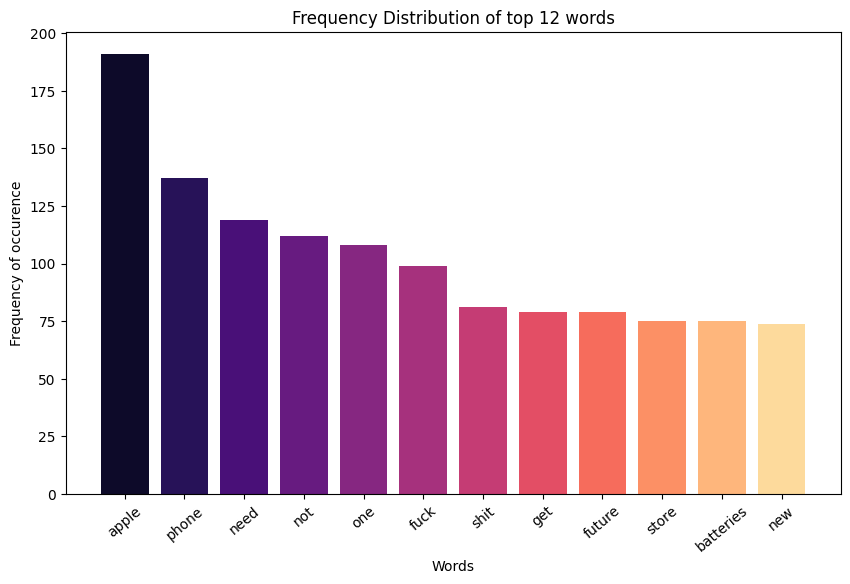

In [87]:
from collections import Counter

total_tweets = ' '.join(data2['nostop_word'])
#splitting the tweets in the form string into words
words = total_tweets.split()
words = [word for word in words]
word_counts = Counter(words)
top_words = word_counts.most_common(12)
word_list, frequency_list = zip(*top_words)
colors = sns.color_palette('magma', 12)
plt.figure(figsize=(10, 6)) 
plt.bar(word_list, frequency_list, color = colors)
plt.xlabel('Words')
plt.ylabel('Frequency of occurence')
plt.title('Frequency Distribution of top 12 words')
plt.xticks(rotation=40)
plt.show()